In [1]:
!pip install pretty_midi > /dev/null 2>&1
!pip install librosa > /dev/null 2>&1
!pip install noisereduce > /dev/null 2>&1

In [ ]:
from torch.utils.data import Dataset, DataLoader
import json
import torch
import librosa
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.neighbors import NearestNeighbors
import noisereduce as nr
from scipy import stats
import scipy
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#Data loader (wav and midi files)
class AudioDataset(Dataset):
    def __init__(self, directory,json_file, subset, transform=None):
        with open(directory+json_file, 'r') as f:
            data = json.load(f)
        self.file_list = data[subset]
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_file = self.file_list[idx]
        audio, sr = librosa.load(directory+"wav_data_sync_with_midi/"+audio_file+".wav", sr=None)
        midi=pretty_midi.PrettyMIDI(directory+"midi_data/"+audio_file+".mid")

        if self.transform:
            audio = self.transform(audio)

        return (audio,sr), midi

def get_onset_offset_notes(midi):
  onset,offset,midi_note=[],[],[]
  for instrument in midi.instruments:
      for note in instrument.notes:
          onset.append(note.start)  # onset time in seconds
          offset.append(note.end)  # offset time in seconds
          midi_note.append(note.pitch)  # MIDI note number
  return np.vstack([onset,offset,midi_note]).T


def find_closest_points_knn(points_a, points_b):
    # Reshape points for sklearn compatibility
    points_a = points_a.reshape(-1, 1)
    points_b = points_b.reshape(-1, 1)

    # Fit nearest neighbors model to points_b
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(points_b)

    # Find closest points in points_b for each point in points_a
    distances, indices = nbrs.kneighbors(points_a)

    return points_b[indices.flatten()],indices.flatten()

In [ ]:
def icp_1d(points_a, points_b, max_iterations=100, tolerance=1e-5):
    #Initial translation
    transformed_points_a=np.copy(points_a)
    translation=points_b[0]-points_a[0]
    transformed_points_a = transformed_points_a + translation
    for i in range(max_iterations):
        print(i)
        # Apply transformation
        #transformed_points_a = points_a + translation

        # Find closest points using k-NN
        closest_points,matches= find_closest_points_knn(transformed_points_a, points_b)


        # Update transformation
        new_translation = np.mean(closest_points - transformed_points_a)

        transformed_points_a=transformed_points_a+new_translation
        # Check for convergence
        if np.abs(new_translation - translation) < tolerance:
            break

        translation = new_translation
    translation=np.mean(transformed_points_a - points_a)
    return translation,matches

In [ ]:
directory="/content/drive/MyDrive/MLSP_PROJECT/"
json_file="train_valid_test_keys.json"
train_dataset=AudioDataset(directory,json_file,"TRAIN")
validation_dataset=AudioDataset(directory,json_file,"VALID")
test_dataset=AudioDataset(directory,json_file,"TEST")

In [ ]:
with open(directory+json_file, 'r') as f:
  names = json.load(f)
train_list = names["TRAIN"]
validation_list = names["VALID"]
test_list = names["TEST"]
print(train_list)
print(validation_list)
print(test_list)

['F01_0001_0001_1_D', 'F01_0001_0001_2_D', 'F01_0002_0001_1', 'F01_0004_0001_1_D', 'F01_0004_0001_2_D', 'F01_0005_0001_1', 'F01_0005_0001_2', 'F01_0006_0001_1', 'F01_0006_0002_1', 'F01_0006_0002_2', 'F01_0007_0001_1', 'F01_0007_0001_2', 'F01_0008_0001_1', 'F01_0008_0001_2', 'F01_0009_0001_1_D', 'F01_0009_0001_2_D', 'F01_0010_0001_1', 'F01_0010_0001_2', 'F01_0011_0001_1', 'F01_0011_0001_2', 'F01_0012_0001_1', 'F01_0012_0001_2', 'F01_0013_0001_1_D', 'F01_0013_0001_2_D', 'F01_0014_0001_1', 'F01_0014_0001_2', 'F01_0015_0001_1', 'F01_0015_0001_2', 'F01_0016_0001_1', 'F01_0016_0001_2', 'F01_0016_0002_1_D', 'F01_0016_0002_2_D', 'F01_0017_0001_1', 'F01_0017_0001_2', 'F01_0018_0001_1_D', 'F01_0018_0001_2_D', 'F01_0018_0002_1_D', 'F01_0018_0002_2_D', 'F01_0019_0001_1', 'F01_0019_0001_2', 'F01_0020_0001_1', 'F01_0020_0001_2', 'F01_0020_0002_1', 'F01_0020_0002_2', 'F01_0021_0001_1_D', 'F01_0021_0001_2_D', 'F01_0022_0001_1_D', 'F01_0022_0001_2_D', 'F01_0022_0002_1', 'F01_0022_0002_2', 'F01_0023_000

**Correcting onsets in train dataset**

In [ ]:
for k in range(len(train_list)):
  onset_offset_notes=get_onset_offset_notes(train_dataset[k][1])
  y,sr=train_dataset[k][0]
  estimated_onsets=librosa.onset.onset_detect(y=nr.reduce_noise(y=y, sr=sr), sr=sr, units='time')
  matches=icp_1d(onset_offset_notes[:,0],estimated_onsets)[1]
  np.savetxt(directory+"corrected_onsets/TRAIN/"+train_list[k]+".txt",estimated_onsets[matches])
  if k%500==0:
    print(k, "saved files")
  #plt.plot(y)
  #for t in (estimated_onsets[matches])*sr:
  #  plt.axvline(x=t,color="black")
  #plt.show()

0 saved files
500 saved files
1000 saved files
1500 saved files
2000 saved files
2500 saved files
3000 saved files
3500 saved files
4000 saved files
4500 saved files
5000 saved files
5500 saved files
6000 saved files
6500 saved files
7000 saved files
7500 saved files
8000 saved files
8500 saved files
9000 saved files
9500 saved files
10000 saved files
10500 saved files
11000 saved files
11500 saved files
12000 saved files
12500 saved files


/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:71: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


ParameterError: ignored

In [ ]:
print(k)

12544


In [ ]:
for k in range(12544,len(train_list)):
  onset_offset_notes=get_onset_offset_notes(train_dataset[k][1])
  y,sr=train_dataset[k][0]
  estimated_onsets=librosa.onset.onset_detect(y=np.nan_to_num(nr.reduce_noise(y=y, sr=sr)), sr=sr, units='time')
  matches=icp_1d(onset_offset_notes[:,0],estimated_onsets)[1]
  np.savetxt(directory+"corrected_onsets/TRAIN/"+train_list[k]+".txt",estimated_onsets[matches])
  if k%100==0:
    print(k, "saved files")

/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:71: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


12600 saved files
12700 saved files
12800 saved files
12900 saved files
13000 saved files


In [ ]:
import os

def count_files_in_directory(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

direc = directory+"corrected_onsets/TRAIN/"  # replace with your directory
print(f'There are {count_files_in_directory(direc)} files in the directory.')

There are 13080 files in the directory.


In [ ]:
print(train_dataset.__len__())
print(validation_dataset.__len__())
print(test_dataset.__len__())

13080
765
769


**Correcting onsets in validation dataset**

In [ ]:
for k in range(len(validation_list)):
  onset_offset_notes=get_onset_offset_notes(validation_dataset[k][1])
  y,sr=validation_dataset[k][0]
  estimated_onsets=librosa.onset.onset_detect(y=np.nan_to_num(nr.reduce_noise(y=y, sr=sr)), sr=sr, units='time')
  matches=icp_1d(onset_offset_notes[:,0],estimated_onsets)[1]
  #There is an error in the code below, instead of saving with validation names, i used training list names
  np.savetxt(directory+"corrected_onsets/VALID/"+validation_list[k]+".txt",estimated_onsets[matches])
  if k%50==0:
    print(k, "saved files")

0 saved files
50 saved files
100 saved files
150 saved files
200 saved files
250 saved files
300 saved files
350 saved files
400 saved files
450 saved files
500 saved files
550 saved files
600 saved files
650 saved files
700 saved files
750 saved files


In [ ]:
direc = directory+"corrected_onsets/VALID/"  # replace with your directory
print(f'There are {count_files_in_directory(direc)} files in the directory.')

There are 765 files in the directory.


**Correcting onsets in test dataset**

In [ ]:
for k in range(len(test_list)):
  onset_offset_notes=get_onset_offset_notes(test_dataset[k][1])
  y,sr=test_dataset[k][0]
  estimated_onsets=librosa.onset.onset_detect(y=np.nan_to_num(nr.reduce_noise(y=y, sr=sr)), sr=sr, units='time')
  matches=icp_1d(onset_offset_notes[:,0],estimated_onsets)[1]
  #There is an error in the code below, instead of saving with validation names, i used training list names
  np.savetxt(directory+"corrected_onsets/TEST/"+test_list[k]+".txt",estimated_onsets[matches])
  if k%50==0:
    print(k, "saved files")

0 saved files
50 saved files
100 saved files
150 saved files


/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:71: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


200 saved files
250 saved files


/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:71: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:71: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


300 saved files
350 saved files
400 saved files
450 saved files
500 saved files
550 saved files
600 saved files
650 saved files
700 saved files


/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:71: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


750 saved files


In [ ]:
direc = directory+"corrected_onsets/TEST/"  # replace with your directory
print(f'There are {count_files_in_directory(direc)} files in the directory.')

There are 769 files in the directory.


[[ 0.   0.5 60. ]
 [ 0.5  1.  62. ]
 [ 1.   1.5 64. ]
 [ 1.5  2.  65. ]
 [ 2.   2.5 67. ]
 [ 2.5  3.  69. ]
 [ 3.   3.5 71. ]
 [ 3.5  4.  72. ]
 [ 4.   4.5 72. ]
 [ 4.5  5.  71. ]
 [ 5.   5.5 69. ]
 [ 5.5  6.  67. ]
 [ 6.   6.5 65. ]
 [ 6.5  7.  64. ]
 [ 7.   7.5 62. ]
 [ 7.5  8.  60. ]]
8.0
[0.41795918 0.8707483  1.31192744 1.77632653 2.2523356  2.7631746
 3.25079365 3.75002268 4.27247166 4.74848073 4.93424036 5.25931973
 5.7353288  5.96752834 6.2461678  6.7570068  6.80344671 6.96598639
 7.25623583 7.75546485]


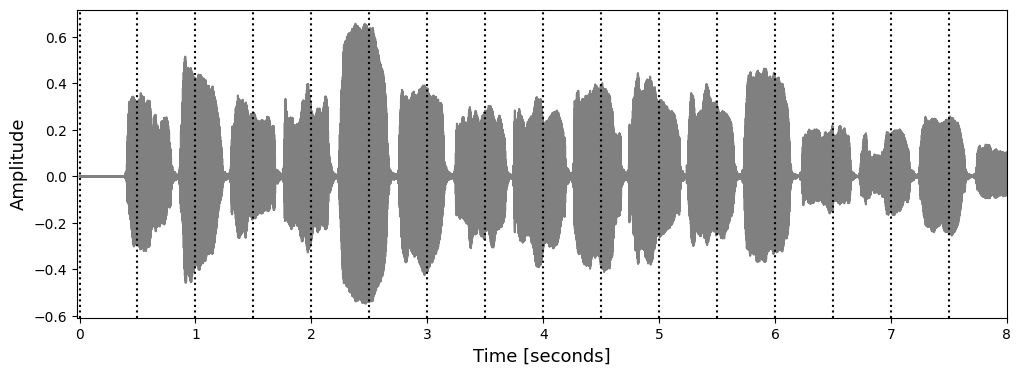

0
1
2
3
4


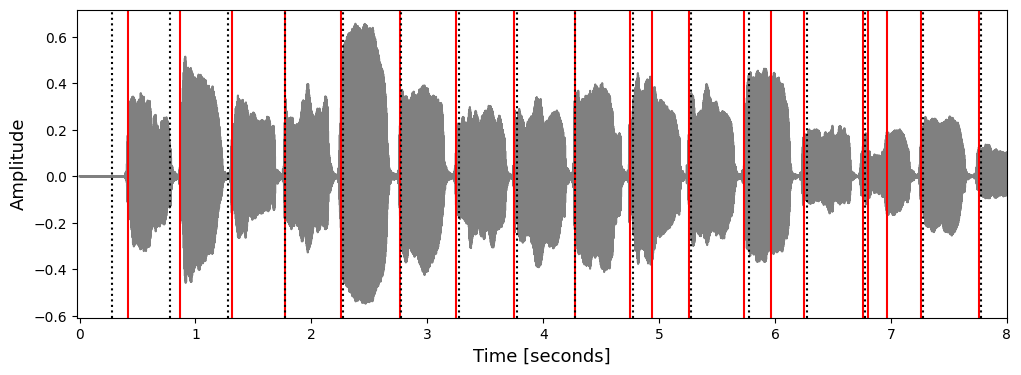

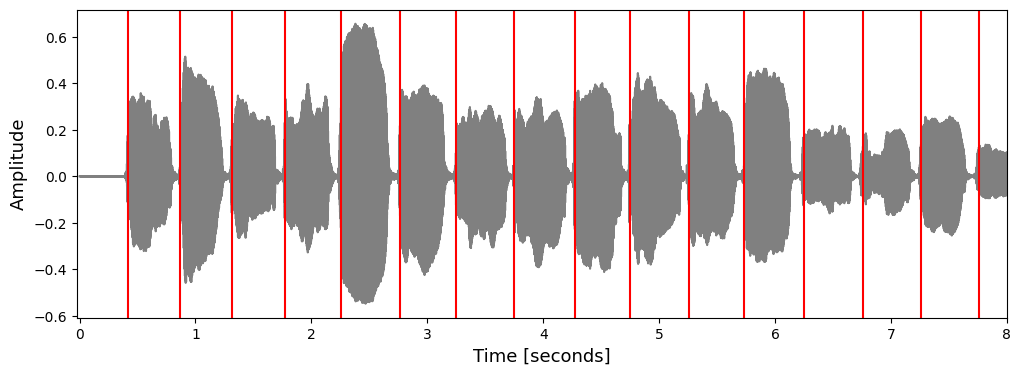

In [ ]:
plt.rcParams["figure.figsize"] = (12,4)
k=0
onset_offset_notes=get_onset_offset_notes(train_dataset[k][1])
print(onset_offset_notes)
y,sr=train_dataset[k][0]
print(y.shape[0]/sr)
estimated_onsets=librosa.onset.onset_detect(y=nr.reduce_noise(y,sr=sr), sr=sr, units='time')

#estimated_offsets=(y.shape[0]/sr-librosa.onset.onset_detect(y=nr.reduce_noise(y=y[::-1], sr=sr), sr=sr, units='time'))[::-1]#+y.shape[0]/sr

print(estimated_onsets)
#print(estimated_offsets)

plt.plot(y,c="gray")
for t in (onset_offset_notes[:,0])*sr:
  plt.axvline(x=t,color="black",linestyle="dotted")
#for t in (onset_offset_notes[:,1])*sr:
#  plt.axvline(x=t,color="red")
#plt.xticks([])
plt.xlabel("Time [seconds]", size=13)
plt.ylabel("Amplitude",size=13)
plt.xlim(-1000,y.shape[0])
time=np.array([0,1,2,3,4,5,6,7,8])
plt.xticks(time*sr,time)
plt.savefig("onset_correction_A.jpg",dpi=300,bbox_inches='tight')
plt.show()

#plt.plot(y)
#tx,matches=icp_1d(onset_offset_notes[:,0],estimated_onsets)
#print(tx)

#for t in (onset_offset_notes[:,0]+tx)*sr:
#  plt.axvline(x=t,color="black")
#for t in (onset_offset_notes[:,1]+tx)*sr:
#  plt.axvline(x=t,color="red")

#plt.xticks(time*sr,time)
#plt.xlim(0,y.shape[0])

#plt.show()





######################
tx,matches=icp_1d(onset_offset_notes[:,0],estimated_onsets)
plt.plot(y,c="gray")
for t in (estimated_onsets)*sr:
  plt.axvline(x=t,color="red")
for t in (onset_offset_notes[:,0]+tx)*sr:
  plt.axvline(x=t,color="black", linestyle="dotted")

plt.xlabel("Time [seconds]", size=13)
plt.ylabel("Amplitude",size=13)
plt.xlim(-1000,y.shape[0])
plt.xticks(time*sr,time)
plt.savefig("onset_correction_B.jpg",dpi=300,bbox_inches='tight')

plt.show()

########################
plt.plot(y,c="gray")
for t in (estimated_onsets[matches])*sr:
  plt.axvline(x=t,color="red")

plt.xlabel("Time [seconds]", size=13)
plt.ylabel("Amplitude",size=13)
plt.xlim(-1000,y.shape[0])
plt.xticks(time*sr,time)

plt.savefig("onset_correction_C.jpg",dpi=300,bbox_inches='tight')

plt.show()

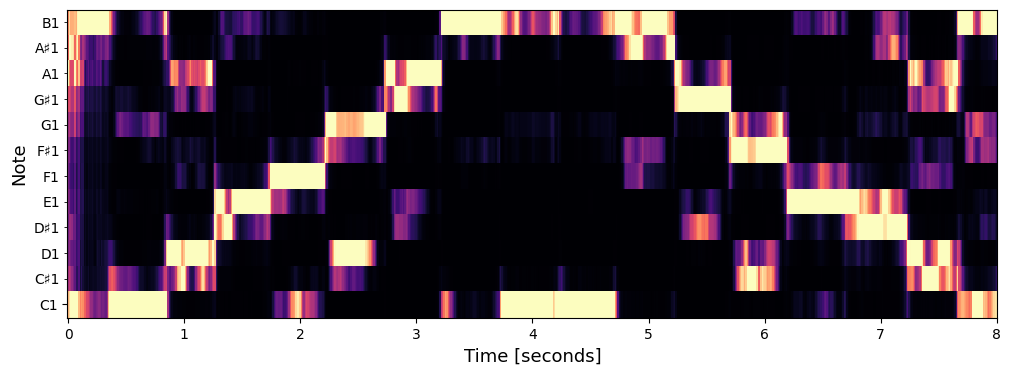

In [ ]:
y_harm = librosa.effects.harmonic(y=y, margin=50)
chroma_harm = librosa.feature.chroma_cqt(y=y_harm, sr=sr)
img = librosa.display.specshow(chroma_harm,sr=sr, y_axis='cqt_note', x_axis='time')
#fig.colorbar(img, ax=ax)
#for t in (estimated_onsets[matches]):
#  plt.axvline(x=t,color="lime")
plt.xlabel("Time [seconds]",size=13)
plt.ylabel("Note",size=13)
plt.savefig("Chroma.jpg",dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
time_bins=(estimated_onsets[matches]*chroma_harm.shape[1]/(y.shape[0]/sr)).astype(int)
time_bins=np.hstack([time_bins,chroma_harm.shape[1]])


n=0
pitches=[]

for t in range(time_bins.shape[0]-1):
  pitch=np.argmax(chroma_harm[:,time_bins[t]:time_bins[t+1]],axis=0)
  most_frequent_pitch=np.argmax(np.bincount(pitch))
  pitches.append(most_frequent_pitch)

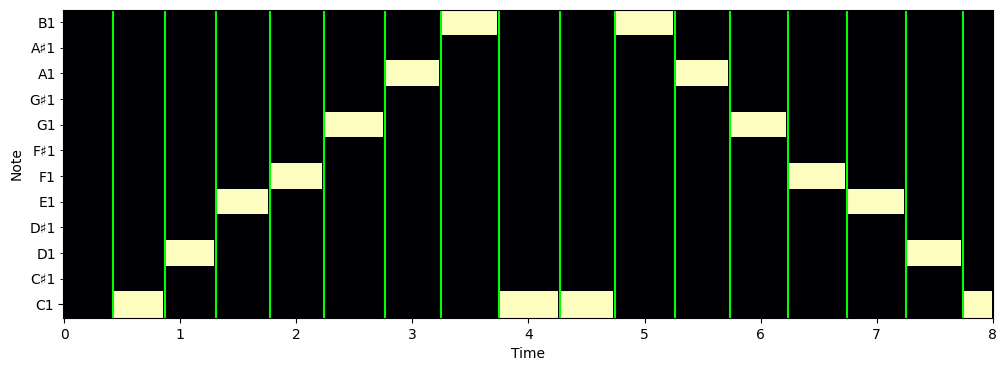

In [ ]:
ground_truth_CQT=np.zeros(chroma_harm.shape)
truth_pitches=(onset_offset_notes[:,2]%12).astype(int)
time_bins=(estimated_onsets[matches]*chroma_harm.shape[1]/(y.shape[0]/sr)).astype(int)
time_bins=np.hstack([time_bins,chroma_harm.shape[1]])
#ground_truth_CQT[:,0:time_bins[0]-1]=0
for t in range(time_bins.shape[0]-1):
  #print(t,truth_pitches[t],)
  ground_truth_CQT[truth_pitches[t],time_bins[t]:time_bins[t+1]-1]=1

img = librosa.display.specshow(ground_truth_CQT,sr=sr, y_axis='cqt_note', x_axis='time')


for t in (estimated_onsets[matches]):
  plt.axvline(x=t,color="lime")



In [ ]:
truth_pitches=onset_offset_notes[:,2]%12
note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
notes = [note_names[int(i)] for i in truth_pitches]
midi_notes = [librosa.note_to_midi(note) for note in notes]
print(notes.__len__())
print(midi_notes)
print(onset_offset_notes[:,2])

16
[12, 14, 16, 17, 19, 21, 23, 12, 12, 23, 21, 19, 17, 16, 14, 12]
[60. 62. 64. 65. 67. 69. 71. 72. 72. 71. 69. 67. 65. 64. 62. 60.]


In [ ]:
#chroma_cq=chroma_cens
time_bins=(estimated_onsets[matches]*chroma_harm.shape[1]/(y.shape[0]/sr)).astype(int)
time_bins=np.hstack([time_bins,chroma_harm.shape[1]])
#print(time_bins)
#print(time_bins)

n=0
pitches=[]
#pitches.append(chroma_cq[:,0:time_bins[0]])
for t in range(time_bins.shape[0]-1):
  pitch=np.argmax(chroma_harm[:,time_bins[t]:time_bins[t+1]],axis=0)
  #print(t)
  most_frequent_pitch=np.argmax(np.bincount(pitch))
  pitches.append(most_frequent_pitch)
  #print(t,most_frequent_pitch)

In [ ]:
midi_notes=pitches

In [ ]:
note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
notes = [note_names[i] for i in pitches]
midi_notes = [librosa.note_to_midi(note) for note in notes]

print(notes)
print(midi_notes)

IndexError: ignored

In [ ]:
onset_times = estimated_onsets[matches]
#onset_times=np.concatenate((np.array([0]),onset_times))

# Calculate note durations by finding the difference between consecutive onsets
note_durations = np.diff(onset_times)

# Calculate the offset times by adding the durations to the onsets
offset_times = onset_times[:-1] + note_durations
offset_times=np.append(offset_times,y.shape[0]/sr)


# Create a PrettyMIDI object
midi = pretty_midi.PrettyMIDI()

# Create an Instrument instance for a piano instrument
piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
piano = pretty_midi.Instrument(program=piano_program)

print(onset_times.shape)
print(offset_times.shape)
print(midi_notes.__len__())
# Perform pitch detection within each onset-offset segment and add notes to the instrument
for onset_time, offset_time,note_number in zip(onset_times, offset_times,midi_notes):

    note_on = onset_time
    note_off = offset_time
    note_velocity = 120
    piano.notes.append(pretty_midi.Note(velocity=note_velocity, pitch=note_number+12*5, start=note_on, end=note_off))
#one octave is 12 semitones, we can add or substract multiples of 12, while keeping the same melody
# Add the instrument to the PrettyMIDI object
midi.instruments.append(piano)

(16,)
(16,)
16


**Example of humming**

In [ ]:
Audio(train_dataset[0][0][0],rate=sr)

**Ground truth midi**

In [ ]:
Audio(midi.synthesize(fs=sr), rate=sr)

**Predicted MIDI with chroma features**

In [ ]:
Audio(train_dataset[0][1].synthesize(fs=sr), rate=sr)